In [30]:
#library imports
import numpy as np #numpy is a math library 
import pandas as pd #pandas is a data library for manipulating information, my main library
import matplotlib as plt #equivalent to R for plotting
import seaborn as sns # a wrapper for matplot lib that makes automatically pretty graphs
from funcsLibPrep import * # this is a custom set of functions, primarily for dealing with applied biosystems data
from scipy import stats # for linear regression later
from scipy import optimize # for polynomials
## stats.gmean for exponential data!!

In [55]:
sns.set(context="talk")

In [31]:
#display magic for seaborn and mpl
%matplotlib inline
sns.set() #set seaborn graphs to be pretty

# nuclei counting match
We can approximate the # of nuclei in each by saying:
* x ng DNA * (1000 pg/1 ng) * (1 nuclei/6pg) = # nuclei relative to cq

In [32]:
# wrapper functions for nuclei <-> ng conversions
def ng_to_nuclei(ng):
    return ng * 1000 / 6
def nuclei_to_ng(nuclei):
    return  nuclei * 6 /1000

In [33]:
# additional wrapper functions for AB systems
def process(fn, data = None):
    sampleSetup = pd.read_excel(fn, 'Sample Setup', skiprows=7)
    df = importAmplification(fn).merge(sampleSetup)
    results = pd.read_excel(fn, skiprows=range(
        0, 7), sheet_name='Results').dropna(thresh=5).dropna(
            axis=1,
            thresh=5).drop(columns=['Task', 'Reporter',
                          'Quencher'])  #import results sheet, drop null rows, drop null columns, drop stupid columns
    results['Ct_clean'] = pd.to_numeric(results['Cт'], errors='coerce') #this is a cleaning line for later
    
    title = fn.rstrip('.xls')
    return df, results, title

# data import and cleaning, v1

In [34]:
## import code
fn = '200805_RachelBoyd_inSituPrimersv1.xls'
amp, results, title = process(fn) #data for v1. "amp" ris a variable we can use for graphing amplification data; results holds our ct results, and title is a helper for naming anything we make with these files

In [35]:
amp.head() #here is what those dataframes look like

,Well,Cycle,Target Name,Rn,ΔRn,Sample Name,Sample Color,Biogroup Name,Biogroup Color,Target Color,Task,Reporter,Quencher,Quantity,Comments
0,A1,1,Col1a,0.228051,-0.031910,5ng,"RGB(223,221,142)",NaN,NaN,"RGB(139,189,249)",UNKNOWN,SYBR,None,NaN,NaN
1,A1,2,Col1a,0.248441,-0.017067,5ng,"RGB(223,221,142)",NaN,NaN,"RGB(139,189,249)",UNKNOWN,SYBR,None,NaN,NaN
2,A1,3,Col1a,0.268417,-0.002638,5ng,"RGB(223,221,142)",NaN,NaN,"RGB(139,189,249)",UNKNOWN,SYBR,None,NaN,NaN
3,A1,4,Col1a,0.273363,-0.003239,5ng,"RGB(223,221,142)",NaN,NaN,"RGB(139,189,249)",UNKNOWN,SYBR,None,NaN,NaN
4,A1,5,Col1a,0.282495,0.000345,5ng,"RGB(223,221,142)",NaN,NaN,"RGB(139,189,249)",UNKNOWN,SYBR,None,NaN,NaN


In [36]:
results.head()

,Well,Sample Name,Target Name,Cт,Cт Mean,Cт SD,Automatic Ct Threshold,Ct Threshold,Automatic Baseline,Baseline Start,Baseline End,Tm1,HIGHSD,EXPFAIL,MTP,Ct_clean
0,A1,5ng,Col1a,21.7995,21.846327,0.066275,1.0,0.14315,1.0,3.0,16.0,82.916039,N,N,N,21.799463
1,A2,5ng,Col1a,21.8932,21.846327,0.066275,1.0,0.14315,1.0,3.0,16.0,82.916039,N,N,N,21.893190
2,A3,.5ng,Col1a,21.8186,21.648956,0.239963,1.0,0.14315,1.0,3.0,17.0,82.915024,N,N,N,21.818636
3,A4,.5ng,Col1a,21.4793,21.648956,0.239963,1.0,0.14315,1.0,3.0,17.0,83.361794,N,N,N,21.479277
4,A5,NTC,Col1a,37.1046,35.261219,2.606960,1.0,0.14315,1.0,3.0,33.0,73.835121,Y,N,N,37.104618


# some Ct examinations

In [37]:
results.groupby(['Target Name', "Sample Name"]).agg({
    "Ct_clean": [stats.gmean, stats.gstd, 'mean', 'std']
}).round(
    2
)  #aggregate the data by the specified columns, and tell us the mean and std deviation of ct in each group. adding geometric mean and geometric standard deviation since these are differences on a log scale. Because n = 2, gmean and mean are the same, but gstd vs std is different. Rounding included for ease of interpretation.

Ct_clean                   
                           gmean  gstd   mean   std
Target Name Sample Name                            
18S         .5ng           18.57  1.03  18.58  0.47
            5ng            17.83  1.00  17.83  0.02
            NTC            33.03  1.06  33.05  1.86
Col1a       .5ng           21.65  1.01  21.65  0.24
            5ng            21.85  1.00  21.85  0.07
            NTC            35.21  1.08  35.26  2.61
Col1a(+)    .5ng           25.30  1.00  25.30  0.07
            5ng            34.65  1.06  34.68  2.08
            NTC              NaN   NaN    NaN   NaN
L1          .5ng           12.75  1.01  12.75  0.18
            5ng            15.09  1.00  15.09  0.05
            NTC              NaN   NaN    NaN   NaN
MTV         .5ng           22.48  1.01  22.48  0.13
            5ng            24.01  1.00  24.01  0.02
            NTC            34.99  1.00  34.99  0.13

This data set looks flipped -- 2 of 5 primer sets show a correct 3 cycle difference, but the opposite of what they are marked. An additional + control shows great amplification with .5 ng and no amplification with 5ng. The other 2 have erratic cq values. It's also possible that the Qubit value on the gDNA is inaccurate, and what we *think* is 5 ng is actually more like 20, and thus inhibitory. Still informative for practice!

# Some nuclei calculations

## plotting these is informative

# Nuclei approximations

In [38]:
#setting up approximate measurements
tipDict = {
    "P1000": 1.1,
    "P300": 1,
    "P20": .75,
    "P10": .6
}  

# fiji approximations
area_umSq = 10000 #measured with Fiji
nuclei = 25 #hand counted, not accounting for z stacking
density = nuclei / area_umSq #math

In [39]:
punch = pd.DataFrame.from_dict(tipDict, orient="index",
                               columns=['diam_mm']).reset_index().rename(
                                   {"index": "template"},
                                   axis=1)  #convert to dataframe + clean up
punch['area_mm_sq'] = punch['diam_mm'].apply(
    lambda diam: np.pi * np.square(diam / 2))
punch['area_uM_sq'] = punch['area_mm_sq'] * np.square(
    1000)  #important to do *squared* dimensional analysis
punch['total_nuclei'] = punch['area_uM_sq'] * density
punch['ng'] = punch.total_nuclei.apply(nuclei_to_ng)

In [40]:
templates = {'High(5ng)': 5, 'Low(0.5ng)': .5, 'NTC': 0}
temp = pd.DataFrame.from_dict(templates, orient="index",
                              columns=['ng']).reset_index().rename(
                                  {"index": "template"}, axis=1)
temp['total_nuclei'] = temp.ng.apply(ng_to_nuclei)

In [41]:
templates = punch.append(temp, sort = False)

In [42]:
templates.round(2) # ball park estimates for comparing to later data

,template,diam_mm,area_mm_sq,area_uM_sq,total_nuclei,ng
0,P1000,1.10,0.95,950331.78,2375.83,14.25
1,P300,1.00,0.79,785398.16,1963.50,11.78
2,P20,0.75,0.44,441786.47,1104.47,6.63
3,P10,0.60,0.28,282743.34,706.86,4.24
0,High(5ng),NaN,NaN,NaN,833.33,5.00
1,Low(0.5ng),NaN,NaN,NaN,83.33,0.50
2,NTC,NaN,NaN,NaN,0.00,0.00


# v3 standard curves of gel punches x primers for amplicons represented in the genome at ~standard curve amounts

In [43]:
fn = '200807_RBoyd_gel-ampliconStdcurve_v3.xls'
amp, results, title = process(fn)

## some visualization

In [44]:
#Dropping the high because something is off with that -- this replicates the previous iteration, which implies something? odd with the template. Re-Qubit.

amp_noHigh = amp.query('`Sample Name` != "High(5ng)"')

## diy standard curve

In [45]:
#dict for approximate values
genome_copies = {
    "col1a1": 2,
    "mtv": 10,
    "18s": 100,
    "L1": 3000,
    "L1half": 1500
}

In [46]:
calc = templates.add_suffix("_calc")
results['genomeCopies'] = results['Target Name'].map(genome_copies)
# d = results[['Well', 'Sample Name', 'Target Name', 'Cт', 'Ct_clean']].copy() #for my SANITY
d = results.merge(calc, left_on = ("Sample Name"), right_on ="template_calc", how = "outer").rename({"Sample Name": "SampleName"}, axis=1)

In [47]:
d['num_amplicons_calc'] = d['total_nuclei_calc']*d['genomeCopies']
d['log2_num_amplicons_calc'] = np.log2(d['num_amplicons_calc'].replace(0, np.nan)).fillna(0)

In [62]:
stds = d.query('SampleName.str.contains("Low")')

x = stds['log2_num_amplicons_calc']
y = stds['Ct_clean']
y_range = [y.min().round(2), y.max().round()]

m, b, r_value, p_value, std_err = stats.linregress(x, y)
ct_line = m*x + b
line_eq = "y={:.2f}x+{:.2f}".format(m, b)

# considering range, not really interested in working  too far outside our range
is_ranged = d['Ct_clean'].between(y.min(), y.max())
ranged = d[is_ranged].copy()
ranged['log2_num_amplicons_curveExp'] = (ranged['Ct_clean'] - b) / m
ranged['num_amplicons_curveExp'] = np.exp2(ranged['log2_num_amplicons_curveExp'])

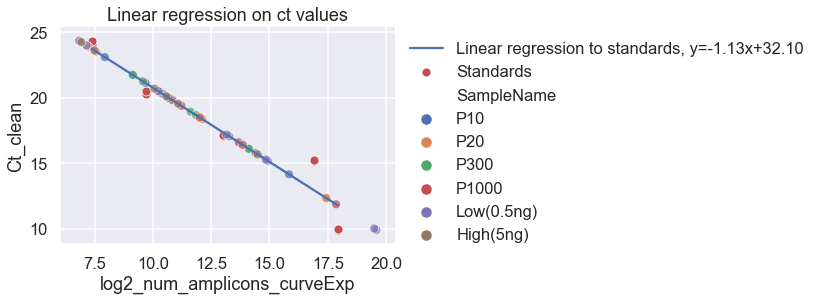

In [73]:
ax = sns.scatterplot(x, y, marker='o', label='Standards', color= "r")
ax = sns.lineplot(x,
                  ct_line,
                  label='Linear regression to standards, {}'.format(line_eq),
                  ax=ax)
ax = sns.scatterplot('log2_num_amplicons_curveExp',
                     'Ct_clean',
                     data=ranged,
                     hue="SampleName",
                     alpha=.7)
# ax = sns.pointplot('log2_num_amplicons_curvecalc',
#                    'Ct_clean',
#                    data=ranged,
#                    join=False,
#                    hue='SampleName', dodge = .5, markers = "x", ax= ax)
sns.despine(ax=ax,
            top=True,
            right=True,
            left=False,
            bottom=False,
            offset=None,
            trim=False)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(title="Linear regression on ct values")

fig = ax.get_figure()

In [52]:
x= 'log2_num_amplicons_calc'
y= 'log2_num_amplicons_curveExp'
m, b, r_value, p_value, std_err = stats.linregress(ranged[x], ranged[y])
ct_line = m*ranged[x] + b
line_eq = "y={:.2f}x+{:.2f}".format(m, b)


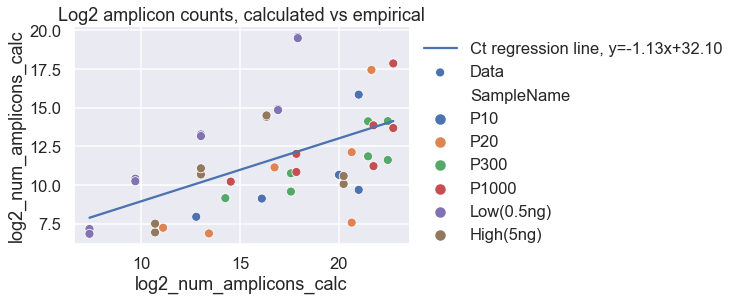

In [60]:
ax = sns.scatterplot(x, y, label="Data", data=ranged, hue="SampleName")
ax = sns.lineplot(
    x, ct_line, 
    label='Ct regression line, {}'.format(line_eq),
    data=ranged,
    ax=ax)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(
        title="Log2 amplicon counts, calculated vs empirical")


sns.despine(ax=ax,
            top=True,
            right=True,
            left=False,
            bottom=False,
            offset=None,
            trim=False)

fig = ax.get_figure()
# fig.show()

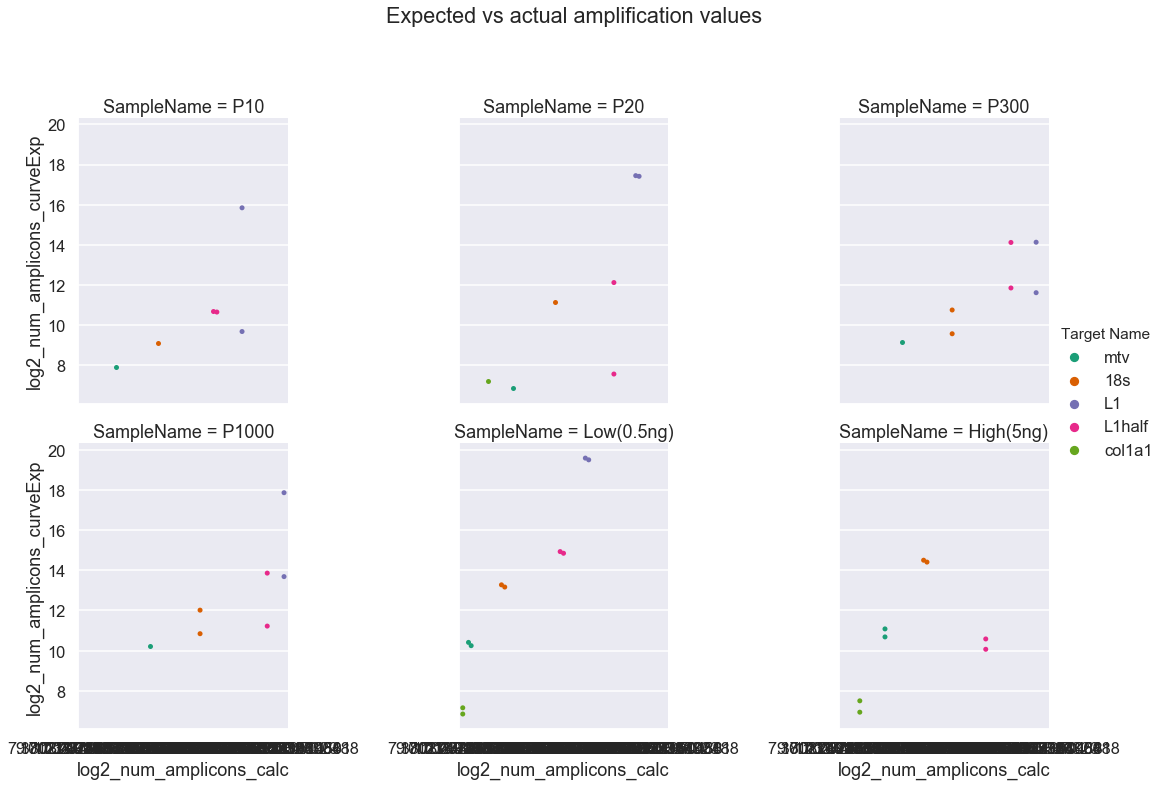

In [59]:
g = sns.catplot(x,
                y,
                hue="Target Name",
                col="SampleName",
                col_wrap=3,
                data=ranged,
                palette='Dark2',
                kind="swarm",
                sharex=True,
                sharey=True)

g = g.fig.suptitle("Expected vs actual amplification values",  x=0.5, y=1.1)

In [ ]:
# def fitFunc(t,a,b):
# #     return a*np.exp(b*t)
# popt, pcov  = optimize.curve_fit(lambda t,a,b: fitFunc(t,a,b),  x,  y, p0=(4, 0.1))

In [ ]:
# xmod =  np.linspace(min(x), max(x))
# ymod = fitFunc(xmod, *popt)
# d['y_fit'] = fitFunc(data_x, *popt)

In [ ]:
# ax = sns.scatterplot(x, y, label = "Fit points")
# ax = sns.lineplot(xmod, ymod, ax = ax)
# ax = sns.scatterplot('Ct_clean',
#                      'y_fit',
#                      hue="SampleName",
#                      data=d,
#                      label='data', ax= ax)

In [ ]:
# # ax = sns.scatterplot(x,y, label = "init")
# sns.lineplot(x, fun(x, popt[0], popt[1]),
#          label='Fitted function')
# # ax = sns.lineplot(x, yfit, label = "fit")

In [ ]:
# x = stds['Ct_clean']
# y = stds['num_amplicons_calc']
# # p, residuals, _, _, _ = np.polyfit(x, y, 2, full=True)
# # chisq_dof = residuals / (len(x) - 3)
# # poly = np.poly1d(p)

In [ ]:
# ax = sns.scatterplot('Ct_clean',
#                      np.log(stds['num_amplicons_calc']),
#                      marker='o',
#                      label='Standards',
#                      data=stds,
#                      color="r")
# ax = sns.lineplot(stds['Ct_clean'],
#                   intercept + slope * stds['Ct_clean'],
#                   label='Linear regression to standards',
#                   ax=ax)
# # ax = sns.scatterplot('Ct_clean',
# #                      intercept + slope * results['Ct_clean'],
# #                      hue="Sample Name",
# #                      data=results,
# #                      label='data',
# #                      ax=ax)

# sns.despine(ax=ax,
#             top=True,
#             right=True,
#             left=False,
#             bottom=False,
#             offset=None,
#             trim=False)
# ax.legend(loc='upper left', bbox_to_anchor=(1.2, 1), frameon=False)
# ax = ax.set(
#     title="Linear regression of ct values",
#     ylabel="Log of num amplicons \n (genome copies x avg nuclei per ng)")

In [ ]:
ranged['log_num_amplicons_experimental'] = intercept + slope * ranged[
    'Ct_clean']  #apply linear regression
ranged['num_amplicons_experimental'] = np.exp(
    ranged['log_num_amplicons_experimental']
)  # undo log transformation. I don't think this is mathematically correct.
ranged['nuclei_experimental'] = ranged['num_amplicons_experimental'] / ranged[
    'genomeCopies']  #this is dubious given that undoing ln

In [ ]:
ranged['ng_experimental'] = ranged['nuclei_experimental'].apply(nuclei_to_ng)

In [ ]:
# sns.boxplot('ng_calc', 'ng_experimental', hue="SampleName", data=ranged)